In [1]:
# importação
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from mlflow.models.signature import infer_signature

In [2]:
# Base de dados
df_credt = pd.read_csv("../data/Credit.csv")
df_credt.shape

(1000, 21)

In [3]:
# cabeçalho
df_credt.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
# Transformando as colunas do tipo 'object' para 'category'
for col in df_credt.columns:
    if df_credt[col].dtype == "object":
        df_credt[col] = df_credt[col].astype("category").cat.codes

In [5]:
df_credt.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [6]:
# Separando as variáveis
previsores = df_credt.iloc[:, 0:20].values
classe = df_credt.iloc[:, 20].values

In [7]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    previsores, classe, test_size=0.3, random_state=123
)

In [8]:
# Criando um banco de dados local
mlflow.set_tracking_uri("sqlite:///mlflow.db")

- Comando para visualizar: mlflow ui --backend-store-uri sqlite:///mlflow.db

In [9]:
# Criando o experimento
def treina_rf(n_estimators):
    mlflow.set_experiment("rfexperimento")
    with mlflow.start_run():
        modelrf = RandomForestClassifier(n_estimators=n_estimators)
        modelrf.fit(X_train, y_train)
        previsoes = modelrf.predict(X_test)

        # Log de hiper parametros
        mlflow.log_param("n_estimators", n_estimators)

        # Métricas
        acuracia = accuracy_score(y_test, previsoes)
        recall = recall_score(y_test, previsoes)
        precision = precision_score(y_test, previsoes)
        f1 = f1_score(y_test, previsoes)
        auc = roc_auc_score(y_test, previsoes)
        log = log_loss(y_test, previsoes)

        # registra métricas
        mlflow.log_metric("acuracia", acuracia)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("log", log)

        # Gráficos
        confusion = sns.heatmap(
            confusion_matrix(y_test, previsoes, labels=[0, 1]),
            annot=True, cmap='Blues', xticklabels=['0', '1'],
            yticklabels=['0', '1'], fmt='g'
        )
        plt.savefig('confusionrf.png')
        roc = RocCurveDisplay.from_estimator(modelrf, X_test, y_test)
        plt.savefig('rocrf.png')

        # Salvar os gráficos
        mlflow.log_artifact('confusionrf.png')
        mlflow.log_artifact('rocrf.png')


        assinatura = infer_signature(X_train, previsoes)

        # Logar o modelo com a assinatura
        mlflow.sklearn.log_model(
            sk_model=modelrf,
            name="modelo_Random_Forest",
            signature=assinatura,
            input_example=X_train[:5]
        )

        # informações da execução
        print("Modelo: ", mlflow.active_run().info.run_id)

2025/12/03 18:51:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/03 18:51:10 INFO mlflow.store.db.utils: Updating database tables
2025-12-03 18:51:10 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-03 18:51:10 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-12-03 18:51:10 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-03 18:51:10 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/12/03 18:51:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modelo:  7e370cbf7c5649ea83a4e92a0feb31bd


2025/12/03 18:51:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modelo:  89693a4638c74d6082af72d71cc5767d


2025/12/03 18:51:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modelo:  3d6f1b9d2dff4114879635db1da6677d


2025/12/03 18:52:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modelo:  e09e8481416547ab9dd7b675d72c9dd2


2025/12/03 18:52:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Modelo:  27d9102920e546648bfac0aef7d929ed


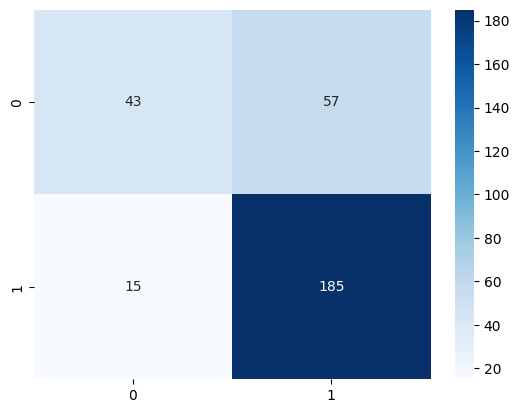

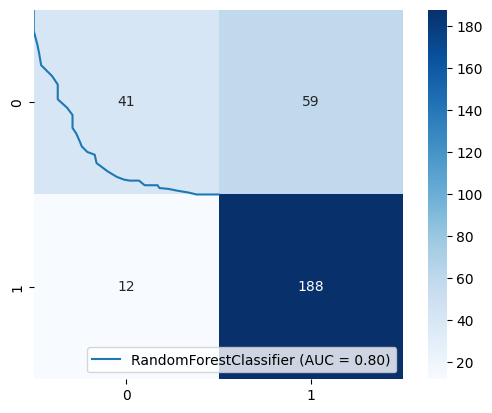

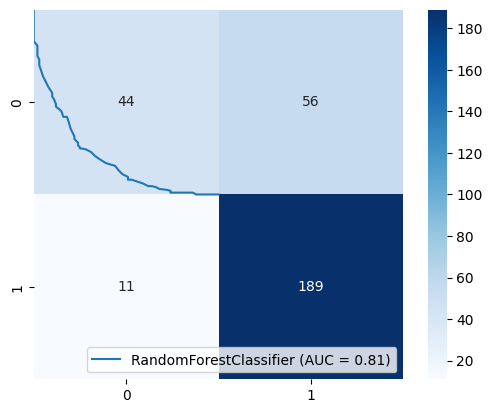

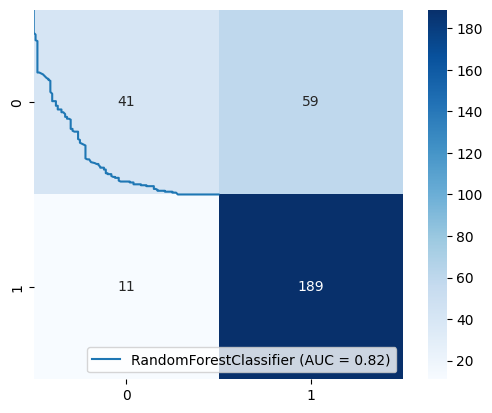

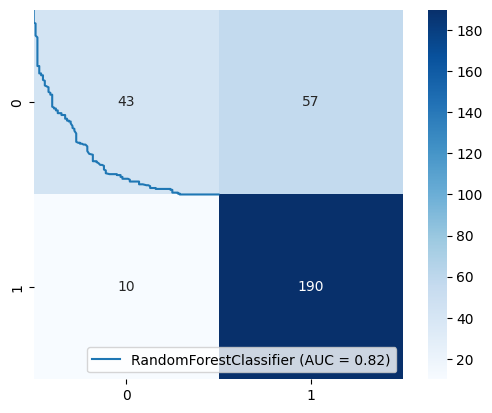

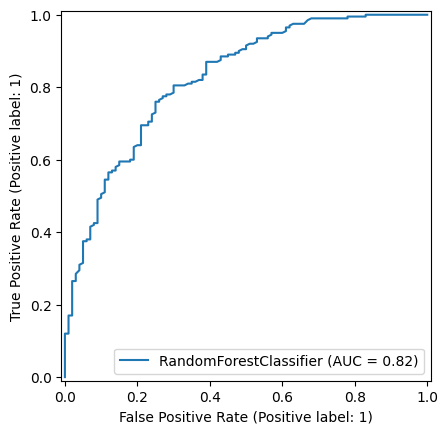

In [10]:
arvores = [50, 100, 500, 750, 1000]
for n in arvores:
    treina_rf(n)